In [1]:
import numpy as np
import img_utils
import itertools
from collections import defaultdict
import sys

In [2]:
#import sys
# From https://github.com/dennybritz/reinforcement-learning/tree/master/lib
# !git clone https://github.com/dennybritz/reinforcement-learning
#if "./reinforcement-learning" not in sys.path:
#  sys.path.append("./reinforcement-learning") 
from lib.envs.gridworld import GridworldEnv
from lib.envs.cliff_walking import CliffWalkingEnv 


In [3]:
def argmax(numpy_array):
    """ argmax implementation that chooses randomly between ties """
    max_indices = np.where(numpy_array == numpy_array.max())[0]
    return max_indices[np.random.randint(max_indices.shape[0])]

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def q_learning(env, num_episodes, discount_factor=0.5, epsilon=0.05, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
  
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode +1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # reset environment at the beginning of every episode
        state = env.reset()
        
        for t in itertools.count():
          
            # Take a step (q-l, not sarsa)
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            
            # TD update
            best_next_action = argmax(Q[next_state])
            
            # NOTE: would this line still if `next_state` is terminal AND Q is NOt initialized to all 0's ?
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta  
            
            if done:
                break
                
            state = next_state
            #action = best_next_action
               
    return Q

In [19]:
from cvxopt import matrix, solvers
from utils import *

def linear_irl(trans_probs, policy, gamma=0.5, l1=1.05, R_max=10):
    """
    inputs:
      trans_probs       NxNxN_ACTIONS transition matrix
      policy            policy vector / map
      R_max             maximum possible value of recoverred rewards
      gamma             RL discount factor
      l1                l1 regularization lambda
    returns:
      rewards           Nx1 reward vector
    """
    print(np.shape(trans_probs))
    N_STATES, _, N_ACTIONS = np.shape(trans_probs)
    N_STATES = int(N_STATES)
    N_ACTIONS = int(N_ACTIONS)

    # Formulate a linear IRL problem
    A = np.zeros([2 * N_STATES * (N_ACTIONS + 1), 3 * N_STATES])
    b = np.zeros([2 * N_STATES * (N_ACTIONS + 1)])
    c = np.zeros([3 * N_STATES])

    for i in range(N_STATES):
        a_opt = np.argmax(policy(i))
        tmp_inv = np.linalg.inv(np.identity(
            N_STATES) - gamma * trans_probs[:, :, a_opt])

        cnt = 0
        for a in range(N_ACTIONS):
            if a != a_opt:
                A[i * (N_ACTIONS - 1) + cnt, :N_STATES] = - \
                    np.dot(trans_probs[i, :, a_opt] -
                           trans_probs[i, :, a], tmp_inv)
                A[N_STATES * (N_ACTIONS - 1) + i * (N_ACTIONS - 1) + cnt, :N_STATES] = - \
                    np.dot(trans_probs[i, :, a_opt] -
                           trans_probs[i, :, a], tmp_inv)
                A[N_STATES * (N_ACTIONS - 1) + i *
                  (N_ACTIONS - 1) + cnt, N_STATES + i] = 1
                cnt += 1

    for i in range(N_STATES):
        A[2 * N_STATES * (N_ACTIONS - 1) + i, i] = 1
        b[2 * N_STATES * (N_ACTIONS - 1) + i] = R_max

    for i in range(N_STATES):
        A[2 * N_STATES * (N_ACTIONS - 1) + N_STATES + i, i] = -1
        b[2 * N_STATES * (N_ACTIONS - 1) + N_STATES + i] = 0

    for i in range(N_STATES):
        A[2 * N_STATES * (N_ACTIONS - 1) + 2 * N_STATES + i, i] = 1
        A[2 * N_STATES * (N_ACTIONS - 1) + 2 * N_STATES +
          i, 2 * N_STATES + i] = -1

    for i in range(N_STATES):
        A[2 * N_STATES * (N_ACTIONS - 1) + 3 * N_STATES + i, i] = 1
        A[2 * N_STATES * (N_ACTIONS - 1) + 3 * N_STATES +
          i, 2 * N_STATES + i] = -1

    for i in range(N_STATES):
        c[N_STATES:2 * N_STATES] = -1
        c[2 * N_STATES:] = l1
    sol = solvers.lp(matrix(c), matrix(A), matrix(b))
    rewards = sol['x'][:N_STATES]
    rewards = normalize(rewards) #* R_max
    return rewards


In [20]:
env = GridworldEnv(shape=[10,10], targets=[0], reward_value=1.0, punishment_value=-1.0)
#env = CliffWalkingEnv()
env.shape

[10, 10]

In [21]:
Q = q_learning(env=env, num_episodes=2000, discount_factor=1.0, epsilon=0.1, alpha=0.5)
policy = make_epsilon_greedy_policy(Q, 0.0, env.action_space.n)

Episode 1999/2000.

map shape: (10, 10), data type: float64


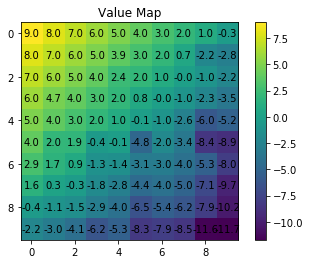

In [22]:
values= []
for i in range(len(Q)):
    values.append(np.max(Q[i]))
values = np.reshape(values, env.shape)
img_utils.heatmap2d(values, 'Value Map')

In [26]:
# Construct transition matrix
P_a = np.zeros((env.nS, env.nS, env.nA))

for state in range(env.nS):
    for action in range(env.nA):
        trans_probs = env.P[state][action][0]
        P_a[state, trans_probs[1], action] = trans_probs[0]

In [27]:
 # solve for the rewards
rewards = linear_irl(P_a, policy, gamma=0.9, l1=1.05, R_max=1)

(100, 100, 4)
     pcost       dcost       gap    pres   dres   k/t
 0:  5.2500e+01 -1.1493e+02  2e+03  3e+00  3e+01  1e+00
 1:  4.2231e+00 -5.6042e+01  5e+02  1e+00  1e+01  1e+00
 2:  2.2574e+00 -1.6197e+01  1e+02  4e-01  4e+00  8e-01
 3:  1.3033e+00 -2.1994e+00  1e+01  7e-02  7e-01  1e-01
 4:  1.7197e-01 -1.7829e-01  1e+00  7e-03  7e-02  6e-03
 5:  1.8025e-03 -1.8379e-03  1e-02  7e-05  8e-04  6e-05
 6:  1.8022e-05 -1.8376e-05  1e-04  7e-07  8e-06  6e-07
 7:  1.8022e-07 -1.8376e-07  1e-06  7e-09  8e-08  6e-09
 8:  1.8022e-09 -1.8376e-09  1e-08  7e-11  8e-10  6e-11
Optimal solution found.


map shape: (10, 10), data type: float64


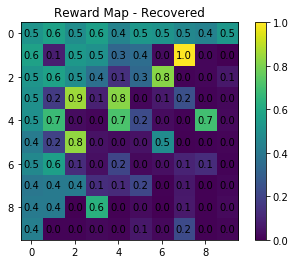

In [28]:
# display recoverred rewards
img_utils.heatmap2d(np.reshape(rewards, env.shape), 'Reward Map - Recovered')
# img_utils.heatmap3d(np.reshape(rewards,  env.shape), 'Reward Map - Recovered')